In [1]:
%%capture
!pip install neurokit2 tqdm

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import neurokit2 as nk
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import find_peaks

# Step 1: Generate Dataset

def generate_ecg_signal(duration, sampling_rate=1000, heart_rate=70, noise_level=0.05):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate)
    noise = np.random.normal(0, noise_level, size=ecg.shape)
    return ecg + noise

def create_dataset(num_samples=1000, duration=2):
    dataset = []
    sampling_rate = 1000

    for _ in range(num_samples):
        maternal_ecg = generate_ecg_signal(duration, sampling_rate, heart_rate=70, noise_level=0.05)
        fetal_ecg = 0.1 * generate_ecg_signal(duration, sampling_rate, heart_rate=120, noise_level=0.1)

        combined_ecg = maternal_ecg + fetal_ecg
        dataset.append((combined_ecg, maternal_ecg, fetal_ecg))

    return dataset

class ECGDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        combined, maternal, fetal = self.dataset[idx]
        return torch.tensor(combined, dtype=torch.float32), torch.tensor(maternal, dtype=torch.float32), torch.tensor(fetal, dtype=torch.float32)

# Step 2: Define the CNN Architecture

class ECGSeparator(nn.Module):
    def __init__(self):
        super(ECGSeparator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 2, kernel_size=3, padding=1) # Output two channels: maternal and fetal
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Step 3: Define Training Pipeline
def kurtosis_loss(k_f, k_m):
    maximize_kf_km = - (k_f + k_m)
    penalty =  10 * torch.relu(k_f - k_m + 0.01)
    loss = maximize_kf_km + penalty
    return torch.mean(loss)

def train_model(model, dataloader, num_epochs=50, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for combined, _, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            combined = combined.unsqueeze(1)  # Add channel dimension
            outputs = model(combined)

            maternal_pred = outputs[:, 0, :]
            fetal_pred = outputs[:, 1, :]

            # Compute kurtosis loss
            k_m = torch.tensor(np.abs(np.nan_to_num([kurtosis(maternal_pred[i].cpu().detach().numpy(), nan_policy='omit') for i in range(maternal_pred.size(0))])), dtype=torch.float32, requires_grad=True)
            k_f = torch.tensor(np.abs(np.nan_to_num([kurtosis(fetal_pred[i].cpu().detach().numpy(), nan_policy='omit') for i in range(fetal_pred.size(0))])), dtype=torch.float32, requires_grad=True)
            #loss_kurtosis = -torch.mean(torch.tensor(np.abs(maternal_kurtosis), dtype=torch.float32, requires_grad=True)) + torch.mean(torch.tensor(np.abs(fetal_kurtosis), dtype=torch.float32, requires_grad=True))

            # Regularization term: MSE between combined input and sum of predictions
            reconstruction = maternal_pred + fetal_pred
            loss_reconstruction = mse_loss(reconstruction, combined.squeeze(1))

            correlation_loss = -torch.mean(torch.abs(torch.cosine_similarity(fetal_pred, maternal_pred, dim=1)))

            loss = kurtosis_loss(k_f, k_m) + loss_reconstruction  + correlation_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

#

In [10]:
# Create the dataset
dataset = create_dataset(num_samples=10000, duration=2)
ecg_dataset = ECGDataset(dataset)
dataloader = DataLoader(ecg_dataset, batch_size=32, shuffle=True)

In [ ]:

model = ECGSeparator()
train_model(model, dataloader, num_epochs=10, learning_rate=0.001)


Epoch 1/10:  53%|█████▎    | 167/313 [00:36<00:29,  5.03it/s]

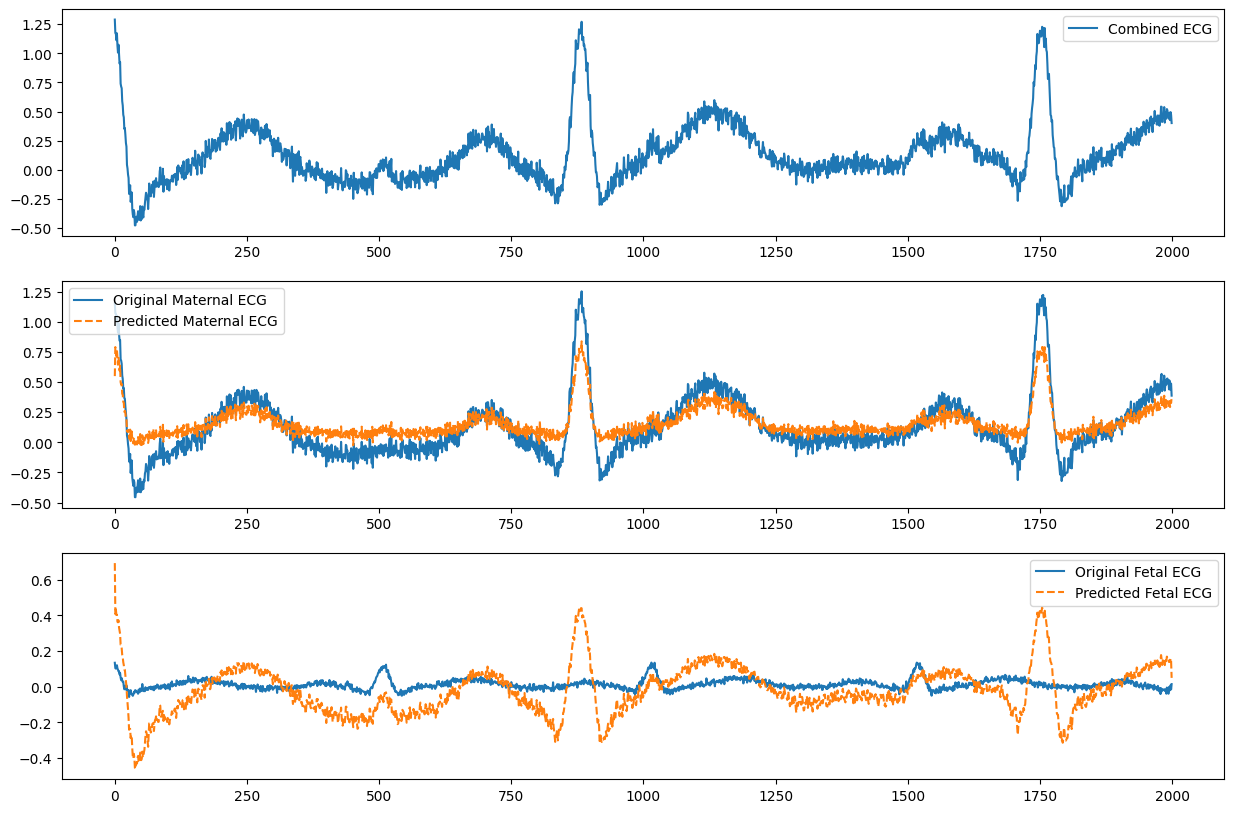

In [44]:
# Load one sample from the dataset
combined, maternal, fetal = ecg_dataset[0]
combined = combined.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Predict separated signals
model.eval()
with torch.no_grad():
    output = model(combined)
    maternal_pred = output[0, 0, :].numpy()
    fetal_pred = output[0, 1, :].numpy()

# Plot original and separated signals
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(combined[0, 0, :].numpy(), label='Combined ECG')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(maternal.numpy(), label='Original Maternal ECG')
plt.plot(maternal_pred, label='Predicted Maternal ECG', linestyle='dashed')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(fetal.numpy(), label='Original Fetal ECG')
plt.plot(fetal_pred, label='Predicted Fetal ECG', linestyle='dashed')
plt.legend()

plt.show()